In [335]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation

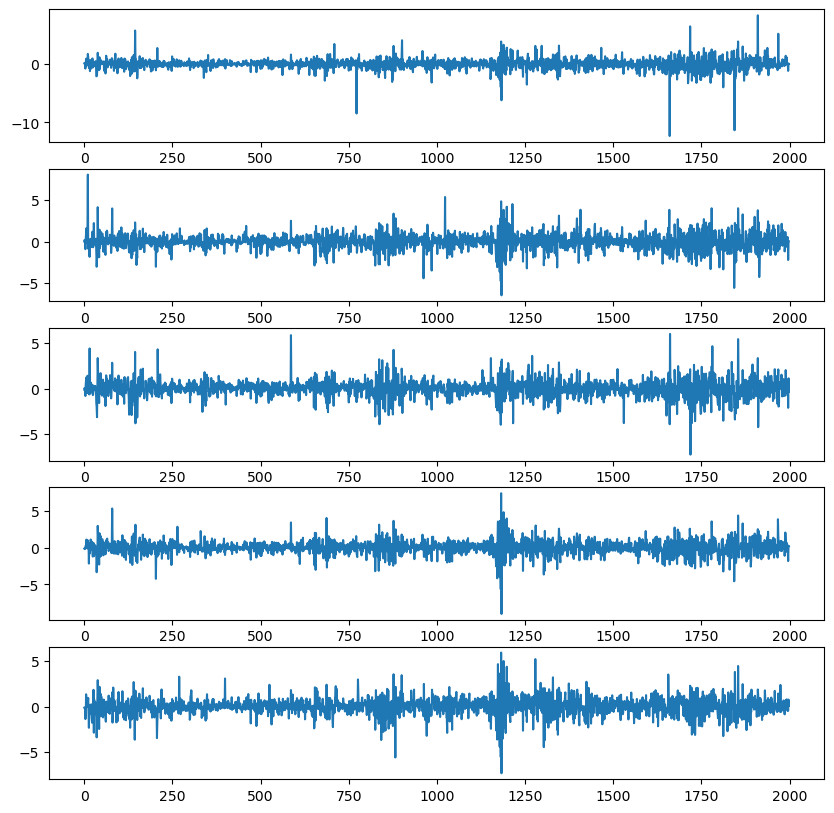

In [336]:
data_META = pd.read_csv("Financial-Data/stocks/META.csv")
data_GOOG = pd.read_csv("Financial-Data/stocks/GOOG.csv")
data_AMZN = pd.read_csv("Financial-Data/stocks/AMZN.csv")
data_MSFT = pd.read_csv("Financial-Data/stocks/MSFT.csv")
data_AAPL = pd.read_csv("Financial-Data/stocks/AAPL.csv")


data_list = [data_META, data_GOOG, data_AMZN, data_MSFT, data_AAPL]

n_obs = 2000
data_close_list = [data['Close'].iloc[-n_obs:].values for data in data_list]

log_ret_list = [np.diff(np.log(data_close)) for data_close in data_close_list]

log_ret_norm_list = [(log_ret - np.mean(log_ret)) / np.std(log_ret) for log_ret in log_ret_list]


# Plot log returns on different plots
fig, ax = plt.subplots(len(log_ret_norm_list), 1, figsize=(10, 10))
for i, data in enumerate(log_ret_norm_list):
    ax[i].plot(data)


plt.show()


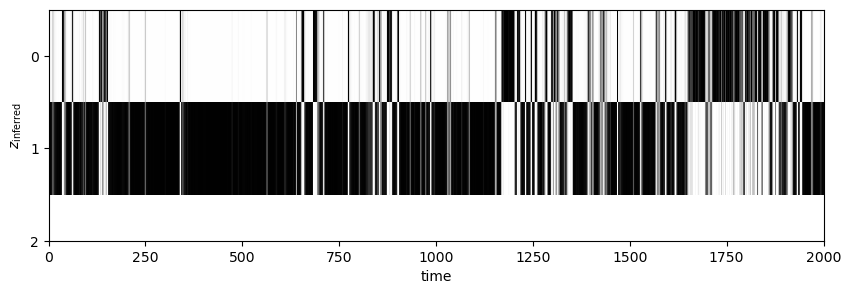

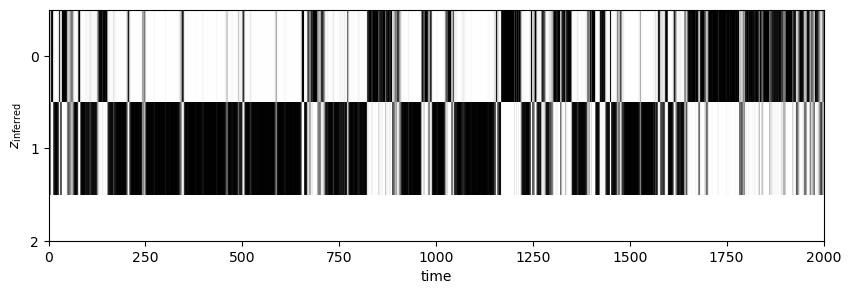

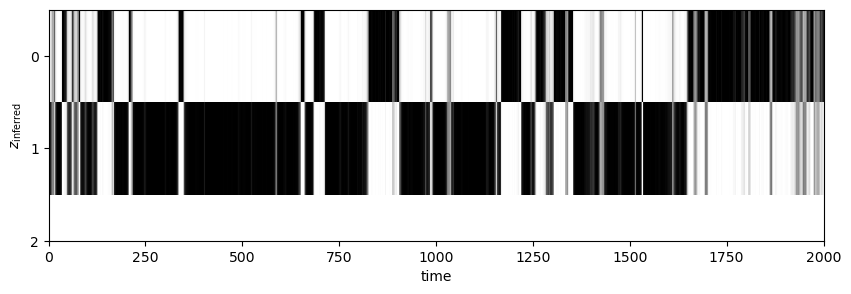

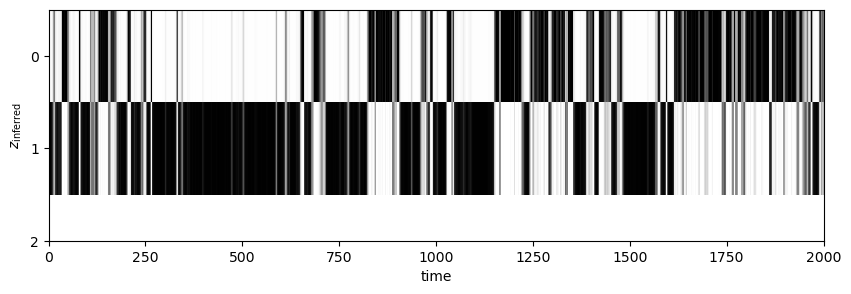

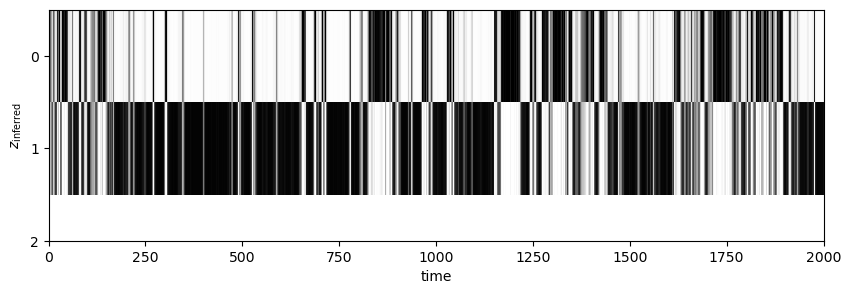

In [337]:
most_likely_states_list = []

for data in log_ret_norm_list:  
    num_states = 2
    emissions = np.array(data).reshape(-1, 1)
    # inputs are shifted emissions
    emission_dim = 1
    num_lags = 10

    # Now fit an HMM to the emissions
    key1, key2 = jr.split(jr.PRNGKey(0), 2)
    test_num_states = num_states

    # Initialize with K-Means
    arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)
    params, props = arhmm.initialize(key=jr.PRNGKey(1), method="kmeans", emissions=emissions)
    inputs = arhmm.compute_inputs(emissions)
    # Fit with EM
    fitted_params, lps = arhmm.fit_em(params, props, emissions, inputs=inputs)
    posterior = arhmm.smoother(fitted_params, emissions, inputs=inputs)
    most_likely_states = arhmm.most_likely_states(fitted_params, emissions, inputs=inputs)
    most_likely_states_list.append(most_likely_states)
    plot_slice = (0, n_obs)
    plt.imshow(posterior.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
    #Make the image shorter and wider
    plt.gcf().set_size_inches(10, 3)
    plt.xlim(plot_slice)
    plt.ylabel("$z_{\\mathrm{inferred}}$")
    plt.yticks([0,1,2])
    plt.xlabel("time")
    plt.show()


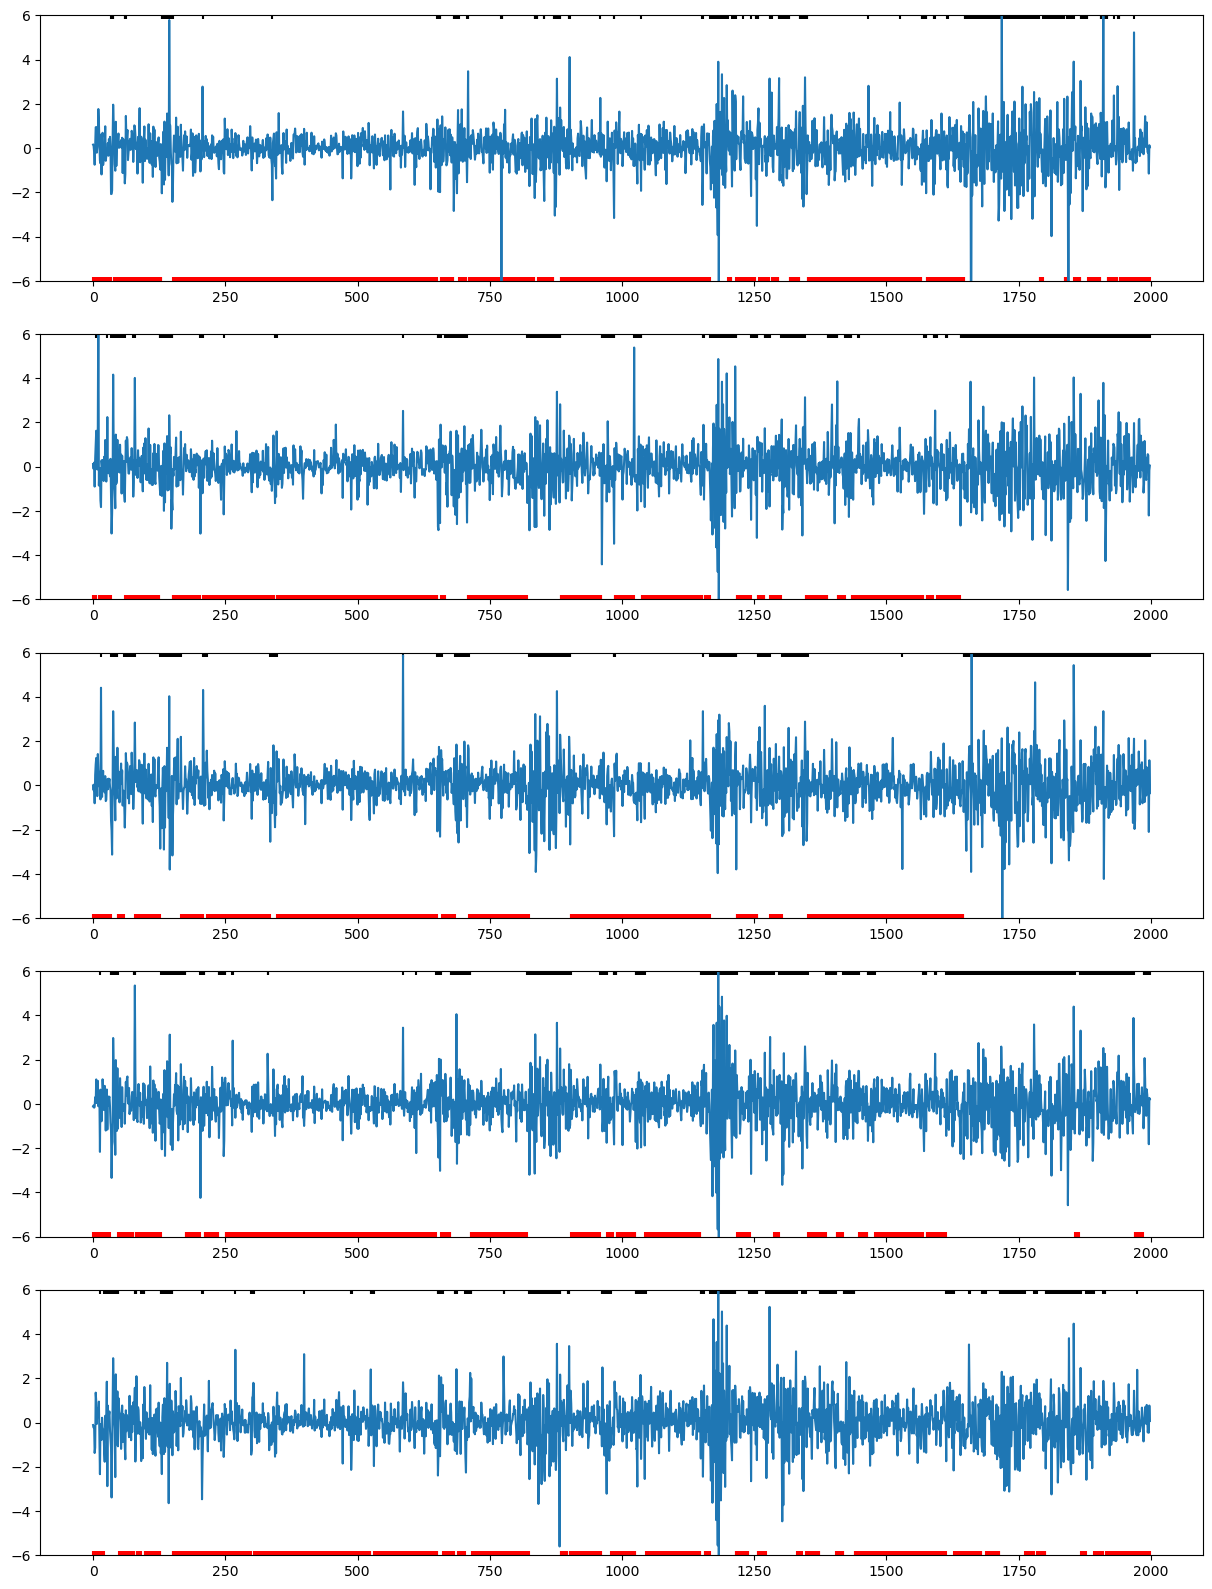

In [338]:
# Plot log returns on different plots
fig, ax = plt.subplots(len(log_ret_norm_list), 1, figsize=(15, 20))
for i, data in enumerate(log_ret_norm_list):
    ax[i].plot(data)
#add most likely states


# Fix ylims to be the same
for i in range(len(log_ret_norm_list)):
    ax[i].set_ylim(-6, 6)

# Substitute state 0 with 0, state 1 with 0.3 and state 2 with -0.

for i in range(len(log_ret_norm_list)):
    most_likely_states = most_likely_states_list[i]
    most_likely_states = np.where(most_likely_states == 0, 6, most_likely_states)
    most_likely_states = np.where(most_likely_states == 1, -6, most_likely_states)
    most_likely_states = np.where(most_likely_states == 2, -6, most_likely_states)
    # scatter the most likely states, color by state
    ax[i].scatter(range(len(most_likely_states)), most_likely_states, c=most_likely_states, marker='|', cmap='flag')

    
plt.show()


In [339]:
for i in range(len(fitted_params)):
    print(fitted_params[i])

ParamsStandardHMMInitialState(probs=Array([0.1291864 , 0.87081367], dtype=float32))
ParamsStandardHMMTransitions(transition_matrix=Array([[0.86870575, 0.13129425],
       [0.06894937, 0.9310506 ]], dtype=float32))
ParamsLinearRegressionHMMEmissions(weights=Array([[[-0.08930294, -0.05126692, -0.03298636, -0.05673249,
          0.04971748, -0.08127473,  0.10274893, -0.12105785,
          0.14816847, -0.04890678]],

       [[ 0.0179901 , -0.01736289,  0.00220059,  0.01593841,
          0.00092657,  0.05087202,  0.02092139,  0.00430895,
         -0.00086462,  0.00065774]]], dtype=float32), biases=Array([[-0.11004642],
       [ 0.04049521]], dtype=float32), covs=Array([[[2.0926058 ]],

       [[0.33710492]]], dtype=float32))
